In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

In [2]:
df = pd.read_csv('dataset.csv')
df.head()

,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Nacionality,Mother's qualification,Father's qualification,Mother's occupation,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,8,5,2,1,1,1,13,10,6,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,6,1,11,1,1,1,1,3,4,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,5,1,1,1,22,27,10,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,8,2,15,1,1,1,23,27,6,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,12,1,3,0,1,1,22,28,10,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


# Feature building

In [3]:
df['1st_sem_perf_ratio'] = (df['Curricular units 1st sem (approved)'] / 
                           df['Curricular units 1st sem (enrolled)']).replace(np.inf, np.nan).fillna(0)

In [4]:
df['2nd_sem_perf_ratio'] = (df['Curricular units 2nd sem (approved)'] / 
                           df['Curricular units 2nd sem (enrolled)']).replace(np.inf, np.nan).fillna(0)

In [5]:
df['grade_diff'] = df['Curricular units 2nd sem (grade)'] - df['Curricular units 1st sem (grade)']

In [6]:
# Avoid division by zero by replacing zeros with NaN before division
df['Failed units ratio'] = 1 - (df['Curricular units 1st sem (approved)'] / 
                                df['Curricular units 1st sem (enrolled)'].replace(0, np.nan))

df['Credit utilization'] = df['Curricular units 1st sem (credited)'] / \
                           df['Curricular units 1st sem (enrolled)'].replace(0, np.nan)

# Fill any NaN values created due to division by zero with a meaningful value (e.g., 0)
df[['Failed units ratio', 'Credit utilization']] = df[['Failed units ratio', 'Credit utilization']].fillna(0)

In [7]:
# Check for any remaining NaN values in the dataset
missing_values = df[['Failed units ratio', 'Credit utilization']].isnull().sum()

print("Missing Values After Processing:")
print(missing_values)

Missing Values After Processing:
Failed units ratio    0
Credit utilization    0
dtype: int64


In [8]:
df['Financial stress'] = (df['Debtor'] & (df['Tuition fees up to date'] == 0)).astype(int)

In [9]:
median_age = df['Age at enrollment'].median()
df['Late_enrollment'] = (df['Age at enrollment'] > median_age).astype(int)

**Parental Influence Index (Combining Qualification & Occupation)**

In [10]:
parent_features = ['Mother\'s qualification', 'Father\'s qualification', 
                   'Mother\'s occupation', 'Father\'s occupation']

In [11]:
pca = PCA(n_components=1)

In [12]:
df['Parental_influence'] = pca.fit_transform(df[parent_features])

In [13]:
target_variable = 'Target'  # Target column
category_features = ['Course', 'Application mode', 'Previous qualification']

# Compute dropout probability for each category
for feature in category_features:
    target_prob = df.groupby(feature)[target_variable].value_counts(normalize=True).unstack()
    
    # Add new probability columns for each category in the target
    for category in target_prob.columns:
        df[f'{feature}_{category}_prob'] = df[feature].apply(lambda x: target_prob[category].get(x, 0))

In [14]:
df.shape

(4424, 52)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 52 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Marital status                                  4424 non-null   int64  
 1   Application mode                                4424 non-null   int64  
 2   Application order                               4424 non-null   int64  
 3   Course                                          4424 non-null   int64  
 4   Daytime/evening attendance                      4424 non-null   int64  
 5   Previous qualification                          4424 non-null   int64  
 6   Nacionality                                     4424 non-null   int64  
 7   Mother's qualification                          4424 non-null   int64  
 8   Father's qualification                          4424 non-null   int64  
 9   Mother's occupation                      

In [16]:
selected_features = df.iloc[:, 46:]

In [17]:
selected_features

,Application mode_Dropout_prob,Application mode_Enrolled_prob,Application mode_Graduate_prob,Previous qualification_Dropout_prob,Previous qualification_Enrolled_prob,Previous qualification_Graduate_prob
0,0.293578,0.182339,0.524083,0.290019,0.187786,0.522195
1,0.166667,0.333333,0.500000,0.290019,0.187786,0.522195
2,0.201991,0.175644,0.622365,0.290019,0.187786,0.522195
3,0.293578,0.182339,0.524083,0.290019,0.187786,0.522195
4,0.554140,0.154140,0.291720,0.290019,0.187786,0.522195
...,...,...,...,...,...,...
4419,0.201991,0.175644,0.622365,0.290019,0.187786,0.522195
4420,0.201991,0.175644,0.622365,0.290019,0.187786,0.522195
4421,0.201991,0.175644,0.622365,0.290019,0.187786,0.522195
4422,0.201991,0.175644,0.622365,0.290019,0.187786,0.522195


In [18]:
# Check for any remaining NaN values in the dataset
missing_values = df.iloc[:, 46:].isnull().sum()

print("Missing Values After Processing:")
print(missing_values)

Missing Values After Processing:
Application mode_Dropout_prob            1
Application mode_Enrolled_prob          16
Application mode_Graduate_prob           2
Previous qualification_Dropout_prob      0
Previous qualification_Enrolled_prob    25
Previous qualification_Graduate_prob    13
dtype: int64


In [19]:
df.iloc[:, 46:] = df.iloc[:, 46:].fillna(0)

In [20]:
# Check for any remaining NaN values in the dataset
missing_values = df.iloc[:, 46:].isnull().sum()

print("Missing Values After Processing:")
print(missing_values)

Missing Values After Processing:
Application mode_Dropout_prob           0
Application mode_Enrolled_prob          0
Application mode_Graduate_prob          0
Previous qualification_Dropout_prob     0
Previous qualification_Enrolled_prob    0
Previous qualification_Graduate_prob    0
dtype: int64


In [41]:
df.to_csv("processed_data/dataset_after_feature_building.csv", index=False)

## Applying log transformations

In [21]:
numerical_features = ['Application order', 'Age at enrollment', 
                      'Curricular units 1st sem (credited)', 
                      'Curricular units 1st sem (enrolled)', 
                      'Curricular units 1st sem (evaluations)', 
                      'Curricular units 1st sem (approved)']

In [22]:
temp = df.copy()

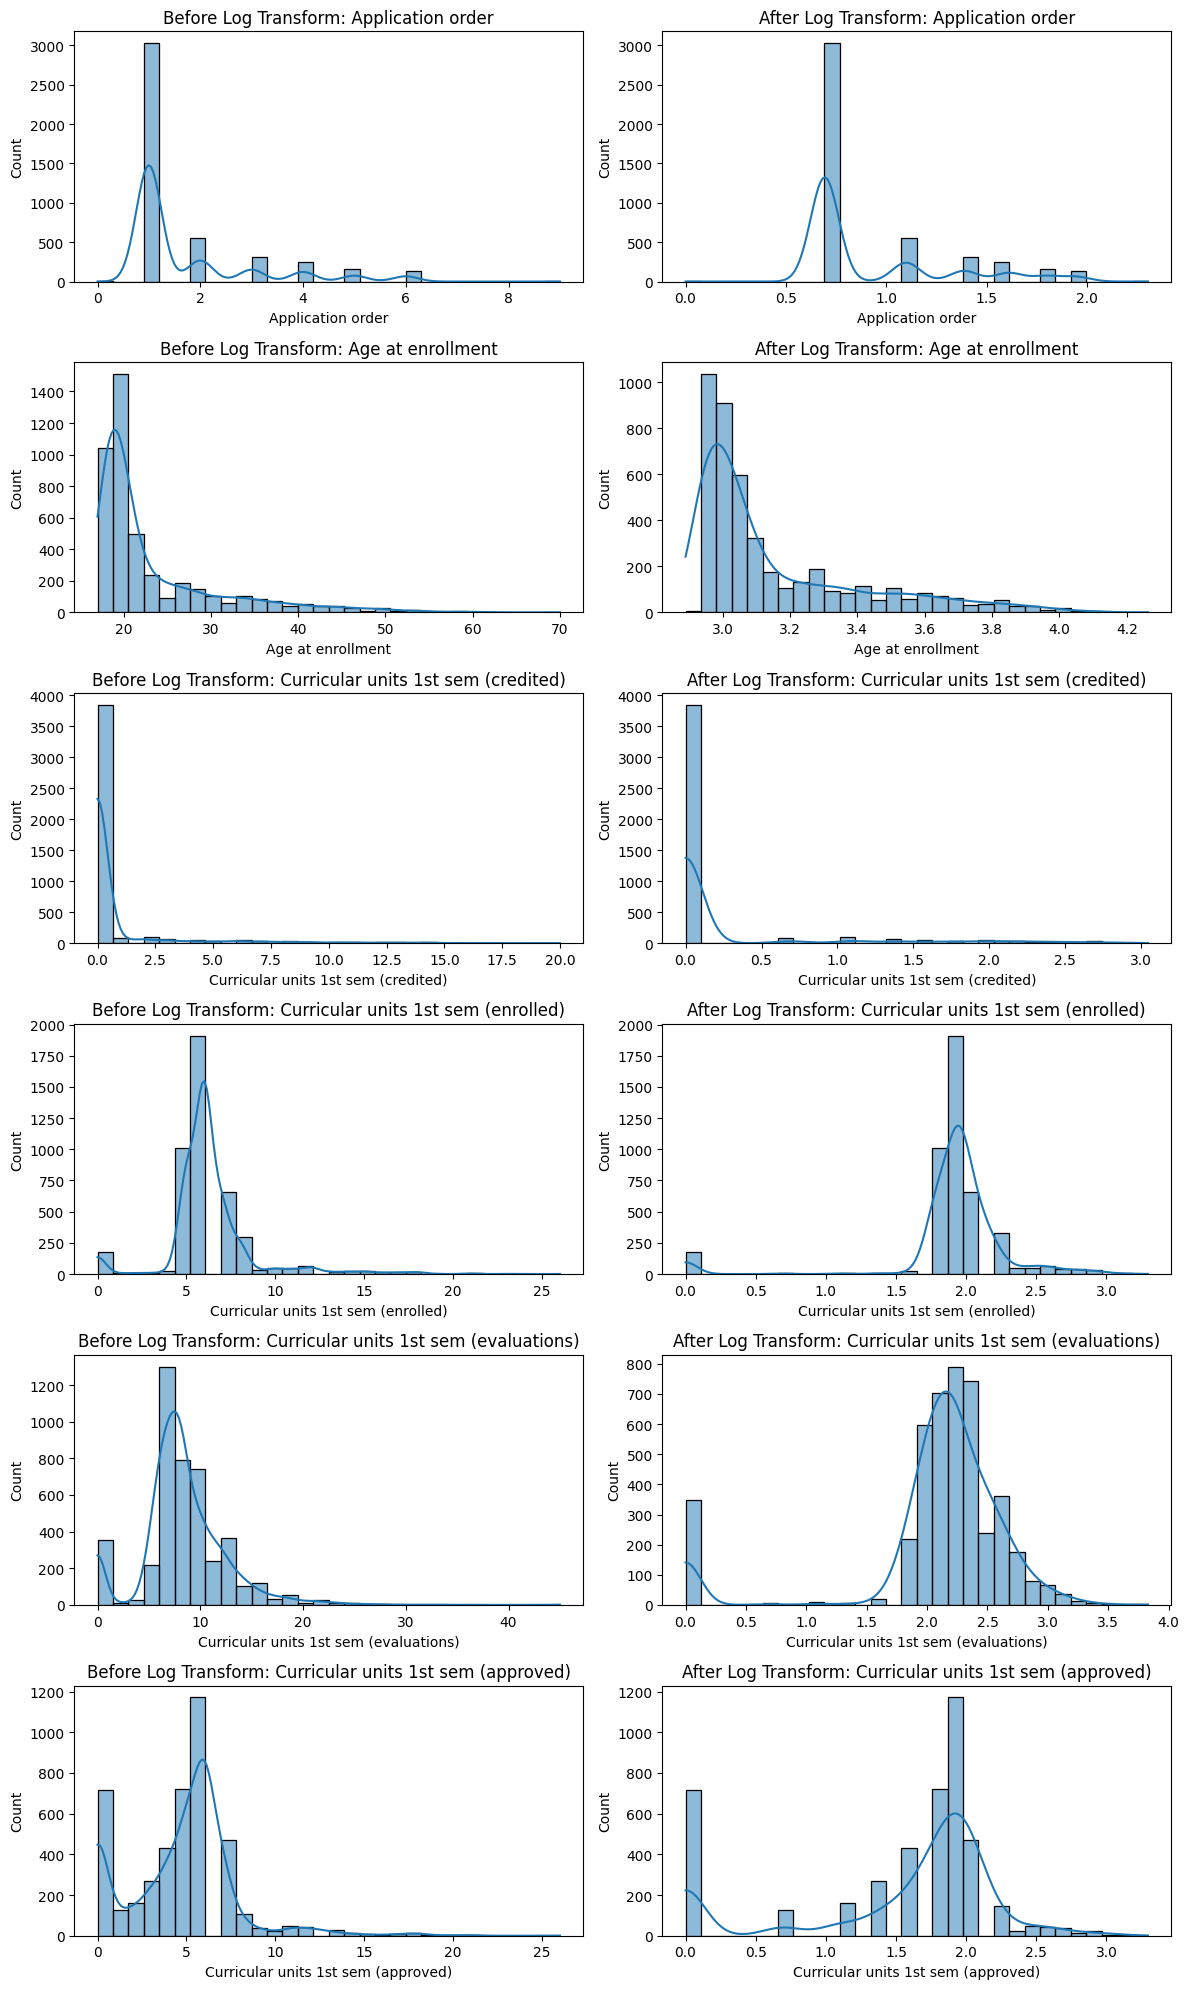

In [23]:
# Plot before and after log transformation
fig, axes = plt.subplots(len(numerical_features), 2, figsize=(12, 20))

for i, col in enumerate(numerical_features):
    sns.histplot(temp[col], bins=30, kde=True, ax=axes[i, 0])
    axes[i, 0].set_title(f'Before Log Transform: {col}')
    
    sns.histplot(np.log1p(temp[col]), bins=30, kde=True, ax=axes[i, 1])
    axes[i, 1].set_title(f'After Log Transform: {col}')

plt.tight_layout()
plt.show()

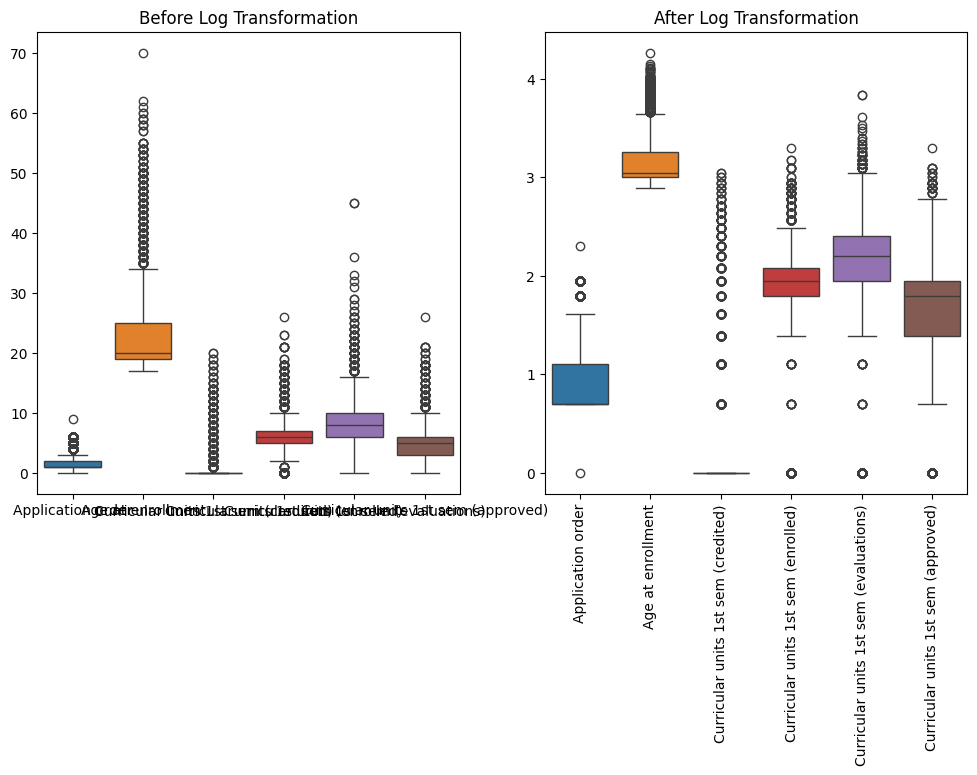

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.boxplot(data=temp[numerical_features], ax=axes[0])
axes[0].set_title("Before Log Transformation")
plt.xticks(rotation=90)

sns.boxplot(data=np.log1p(temp[numerical_features]), ax=axes[1])
axes[1].set_title("After Log Transformation")

plt.xticks(rotation=90)
plt.show()

In [25]:
from scipy.stats import skew

# Compute skewness before and after
skew_before = temp[numerical_features].apply(lambda x: skew(x, nan_policy='omit'))
skew_after = np.log1p(temp[numerical_features]).apply(lambda x: skew(x, nan_policy='omit'))

# Compare skewness
skew_df = pd.DataFrame({'Feature': numerical_features, 'Before': skew_before, 'After': skew_after})
skew_df

,Feature,Before,After
Application order,Application order,1.880412,1.419312
Age at enrollment,Age at enrollment,2.054292,1.513126
Curricular units 1st sem (credited),Curricular units 1st sem (credited),4.167635,2.778291
Curricular units 1st sem (enrolled),Curricular units 1st sem (enrolled),1.618492,-2.756832
Curricular units 1st sem (evaluations),Curricular units 1st sem (evaluations),0.976306,-2.071806
Curricular units 1st sem (approved),Curricular units 1st sem (approved),0.766003,-1.105239


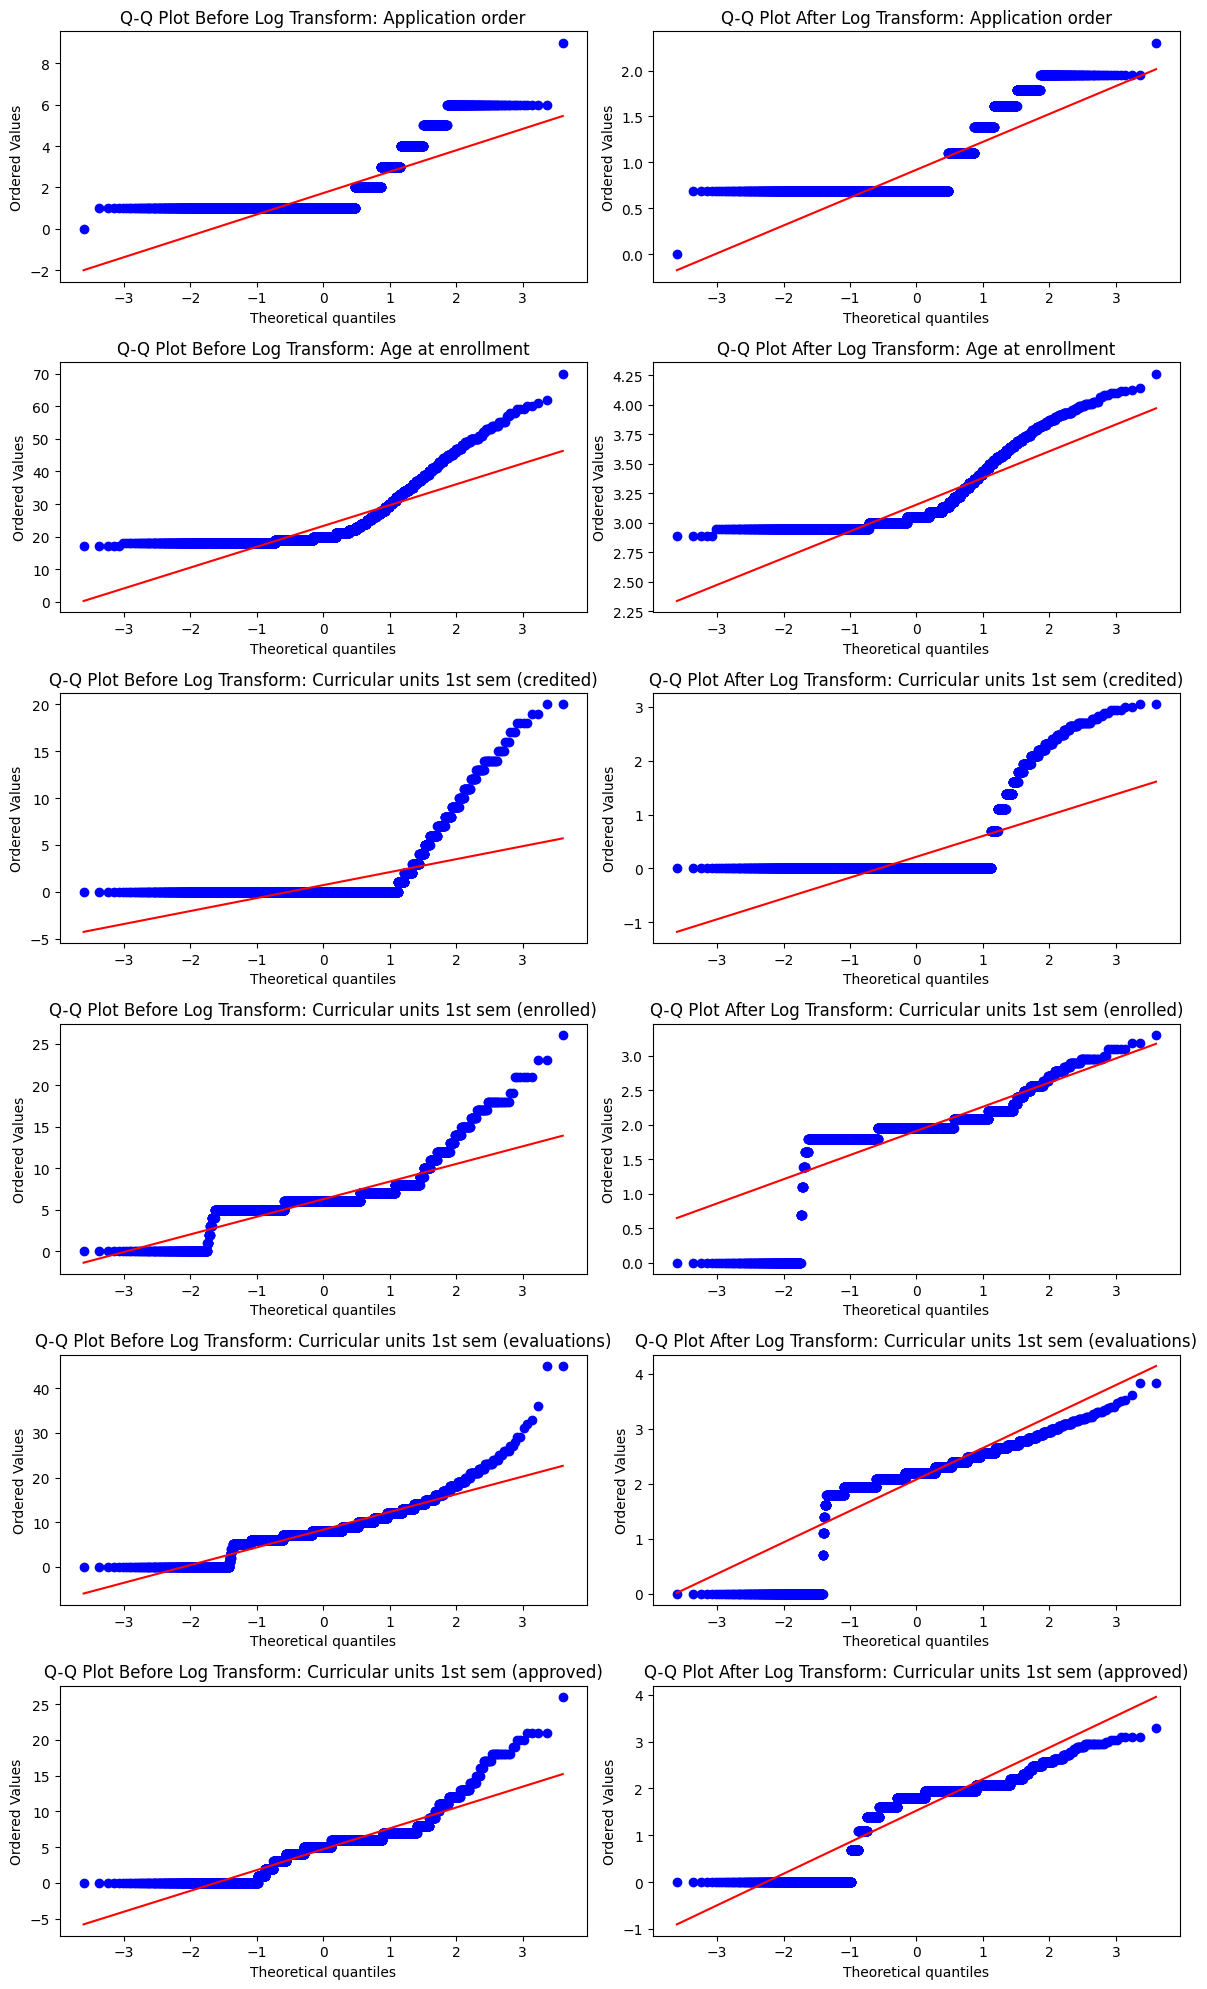

In [26]:
import scipy.stats as stats

fig, axes = plt.subplots(len(numerical_features), 2, figsize=(12, 20))

for i, col in enumerate(numerical_features):
    stats.probplot(temp[col], dist="norm", plot=axes[i, 0])
    axes[i, 0].set_title(f'Q-Q Plot Before Log Transform: {col}')
    
    stats.probplot(np.log1p(temp[col]), dist="norm", plot=axes[i, 1])
    axes[i, 1].set_title(f'Q-Q Plot After Log Transform: {col}')

plt.tight_layout()
plt.show()

## Box Plots Before Outlier Treatment

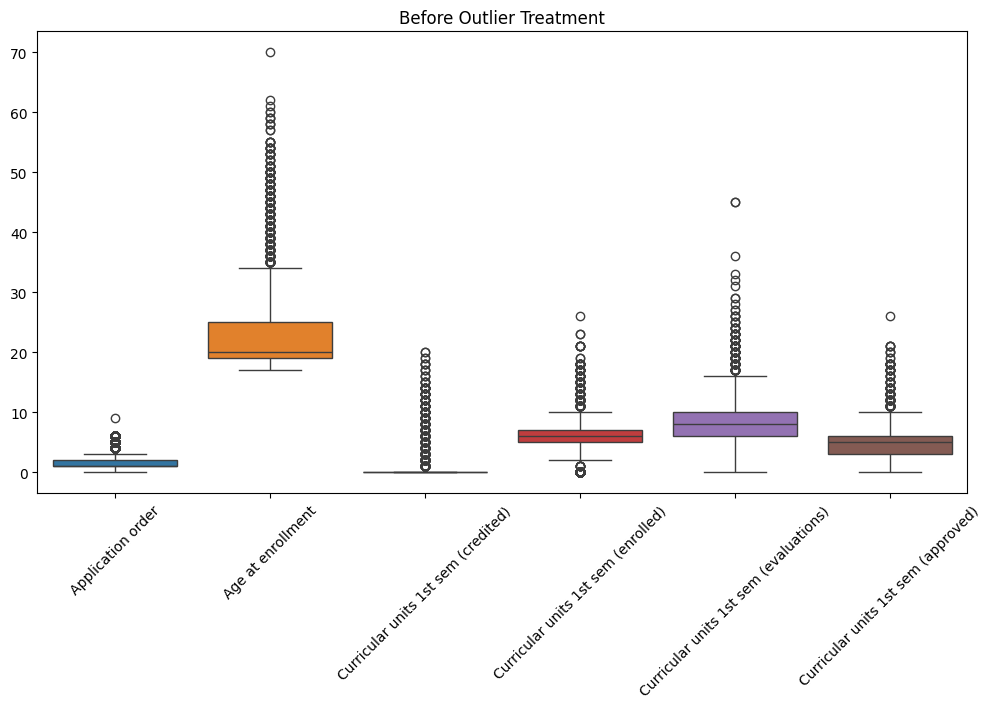

In [27]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.boxplot(data=temp[numerical_features], ax=ax)
ax.set_title("Before Outlier Treatment")
plt.xticks(rotation=45)
plt.show()

In [28]:
temp[numerical_features] = temp[numerical_features].apply(np.log1p)

In [29]:
temp.isna().sum()

Marital status                                    0
Application mode                                  0
Application order                                 0
Course                                            0
Daytime/evening attendance                        0
Previous qualification                            0
Nacionality                                       0
Mother's qualification                            0
Father's qualification                            0
Mother's occupation                               0
Father's occupation                               0
Displaced                                         0
Educational special needs                         0
Debtor                                            0
Tuition fees up to date                           0
Gender                                            0
Scholarship holder                                0
Age at enrollment                                 0
International                                     0
Curricular u

## Detect and Handle Outliers Using Adaptive Winsorization (IQR)

In [30]:
df_outliers = df.copy()

In [31]:
for col in numerical_features:
    Q1 = df_outliers[col].quantile(0.25)  # 25th percentile
    Q3 = df_outliers[col].quantile(0.75)  # 75th percentile
    IQR = Q3 - Q1  # Interquartile Range
    
    # Adaptive Winsorization: Adjust based on data distribution
    k = 1.5  # Default multiplier
    if IQR < 1:  # If IQR is small, increase tolerance to avoid overcorrection
        k = 2.0
    
    lower_bound = Q1 - k * IQR
    upper_bound = Q3 + k * IQR
    
    # Winsorization: Cap outliers at the boundary values instead of removing them
    df_outliers[col] = np.where(df_outliers[col] < lower_bound, lower_bound, df_outliers[col])
    df_outliers[col] = np.where(df_outliers[col] > upper_bound, upper_bound, df_outliers[col])

## Box Plots After Outlier Treatment

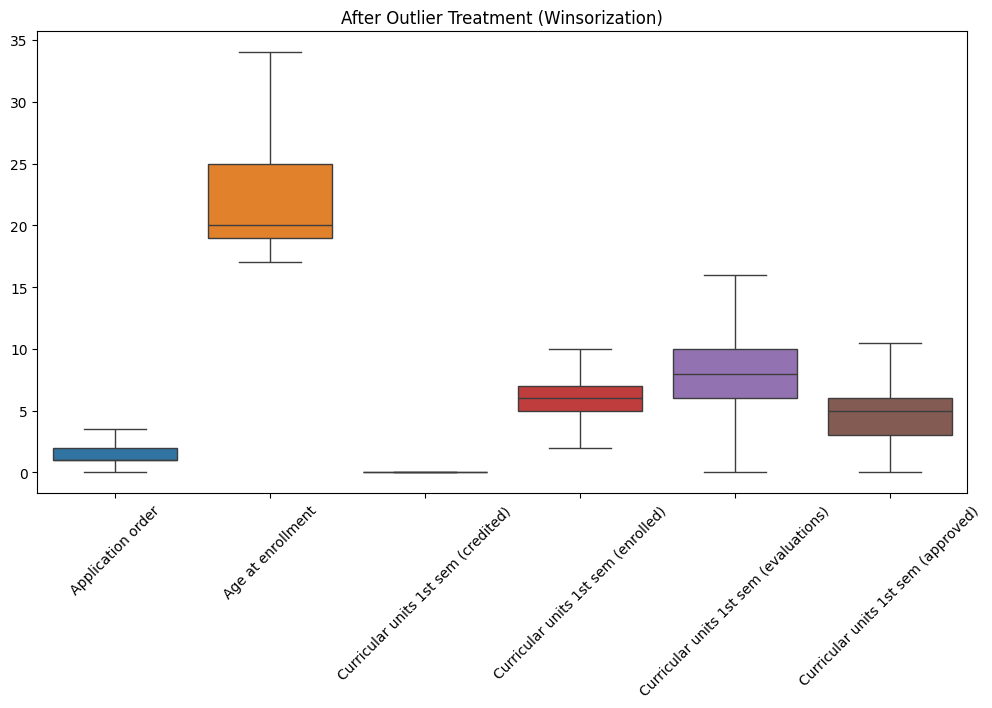

In [32]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.boxplot(data=df_outliers[numerical_features], ax=ax)
ax.set_title("After Outlier Treatment (Winsorization)")
plt.xticks(rotation=45)
plt.show()

## Violin Plots for Distribution Insights

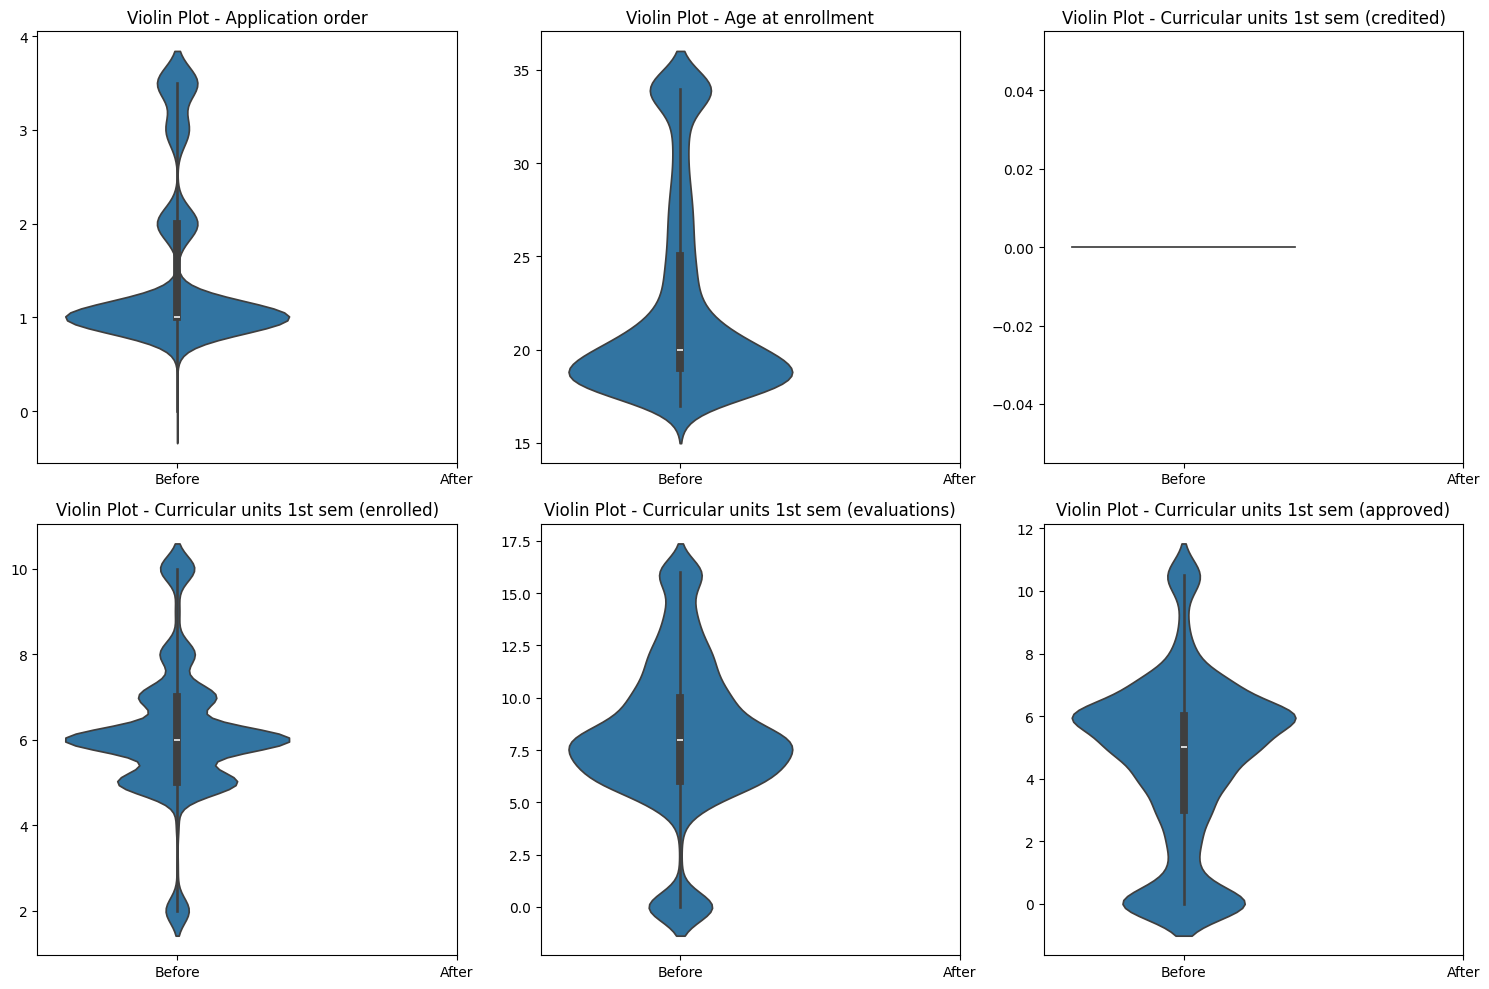

In [33]:
fig, axes = plt.subplots(2, len(numerical_features)//2, figsize=(15, 10))
axes = axes.flatten()
for i, col in enumerate(numerical_features):
    sns.violinplot(data=[df[col], df_outliers[col]], ax=axes[i])
    axes[i].set_title(f"Violin Plot - {col}")
    axes[i].set_xticks([0, 1])
    axes[i].set_xticklabels(["Before", "After"])
plt.tight_layout()
plt.show()

## Histograms Before and After Outlier Treatment

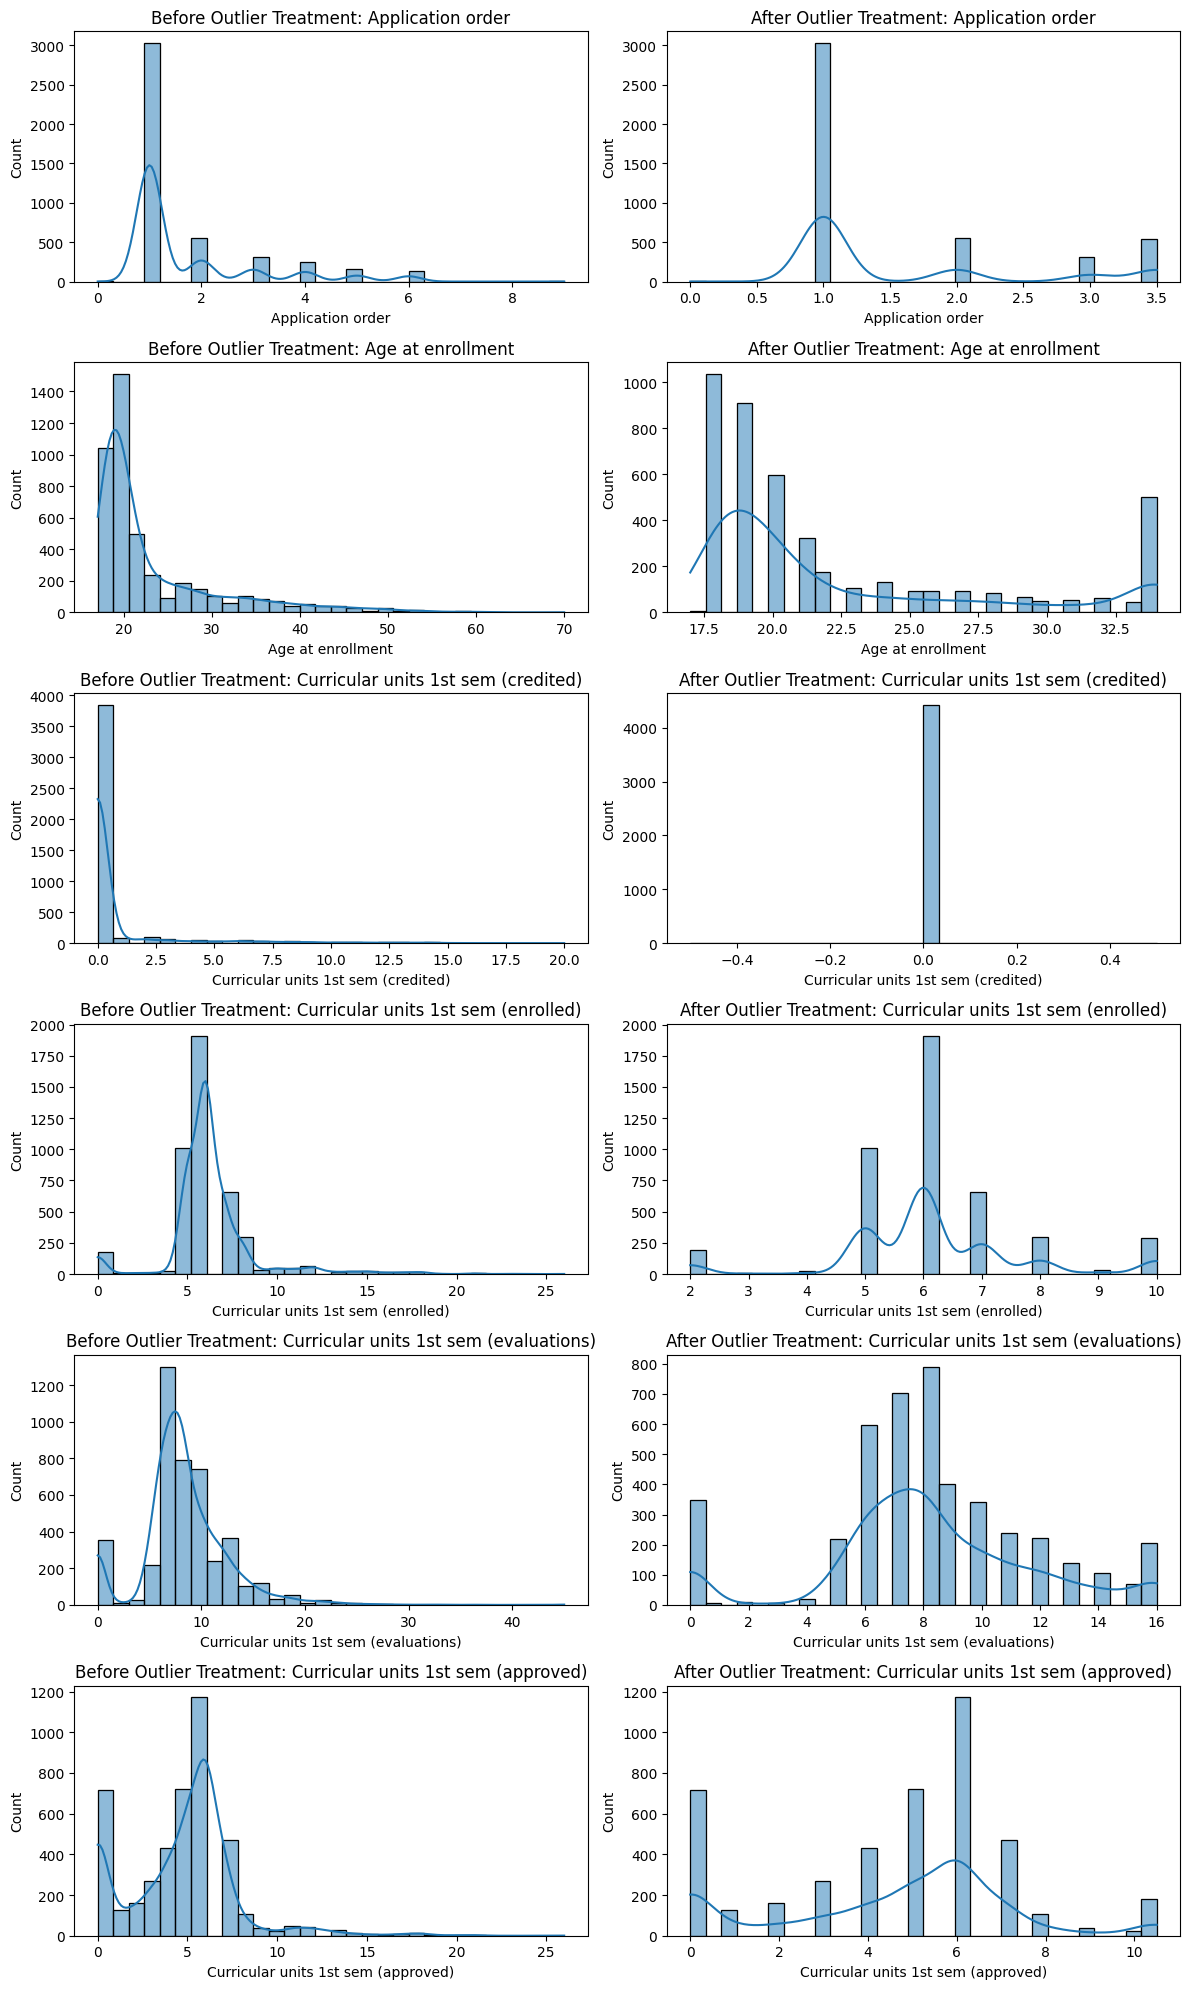

In [34]:
fig, axes = plt.subplots(len(numerical_features), 2, figsize=(12, 20))
for i, col in enumerate(numerical_features):
    sns.histplot(df[col], bins=30, kde=True, ax=axes[i, 0])
    axes[i, 0].set_title(f'Before Outlier Treatment: {col}')
    
    sns.histplot(df_outliers[col], bins=30, kde=True, ax=axes[i, 1])
    axes[i, 1].set_title(f'After Outlier Treatment: {col}')
plt.tight_layout()
plt.show()

## Outlier Count Before and After

In [35]:
outliers_before = df[numerical_features].apply(lambda x: ((x < x.quantile(0.25) - 1.5 * (x.quantile(0.75) - x.quantile(0.25))) | 
                                                           (x > x.quantile(0.75) + 1.5 * (x.quantile(0.75) - x.quantile(0.25)))).sum())

outliers_after = df_outliers[numerical_features].apply(lambda x: ((x < x.quantile(0.25) - 1.5 * (x.quantile(0.75) - x.quantile(0.25))) | 
                                                                   (x > x.quantile(0.75) + 1.5 * (x.quantile(0.75) - x.quantile(0.25)))).sum())

outlier_report = pd.DataFrame({'Feature': numerical_features, 'Outliers Before': outliers_before, 'Outliers After': outliers_after})
print("\n📋 Outlier Count Report:\n")
outlier_report


📋 Outlier Count Report:



,Feature,Outliers Before,Outliers After
Application order,Application order,541,0
Age at enrollment,Age at enrollment,441,0
Curricular units 1st sem (credited),Curricular units 1st sem (credited),577,0
Curricular units 1st sem (enrolled),Curricular units 1st sem (enrolled),424,0
Curricular units 1st sem (evaluations),Curricular units 1st sem (evaluations),158,0
Curricular units 1st sem (approved),Curricular units 1st sem (approved),180,0


## Summary Statistics Before vs. After (Mean, Median, Std)

In [36]:
summary_before = df[numerical_features].describe().T[['mean', '50%', 'std']]
summary_after = df_outliers[numerical_features].describe().T[['mean', '50%', 'std']]
summary_comparison = summary_before.join(summary_after, lsuffix="_Before", rsuffix="_After")

print("\n📋 Summary Statistics Comparison (Before vs. After):\n", summary_comparison)


📋 Summary Statistics Comparison (Before vs. After):
                                         mean_Before  50%_Before  std_Before  \
Application order                          1.727848         1.0    1.313793   
Age at enrollment                         23.265145        20.0    7.587816   
Curricular units 1st sem (credited)        0.709991         0.0    2.360507   
Curricular units 1st sem (enrolled)        6.270570         6.0    2.480178   
Curricular units 1st sem (evaluations)     8.299051         8.0    4.179106   
Curricular units 1st sem (approved)        4.706600         5.0    3.094238   

                                        mean_After  50%_After  std_After  
Application order                         1.568829        1.0   0.918791  
Age at enrollment                        22.457052       20.0   5.409813  
Curricular units 1st sem (credited)       0.000000        0.0   0.000000  
Curricular units 1st sem (enrolled)       6.146022        6.0   1.578002  
Curricular units 

## Observations from Summary Statistics (Before vs. After Winsorization)
### Reduction in Mean & Standard Deviation

* Features like Application Order, Age at Enrollment, and Curricular Units (Evaluations, Approved, etc.) show a drop in mean and standard deviation, indicating that extreme values were capped effectively.
* This suggests that previously extreme values were pulling the mean higher, which is now adjusted.
* Median (50th Percentile) Remains Unchanged

* The 50% (median) value remains the same for all features, confirming that capping only affected extreme values while leaving the core distribution intact.
### Drastic Change in Certain Features

* Curricular Units 1st Sem (Credited) now has a mean and standard deviation of 0, suggesting that all non-zero values were likely capped to zero. This might indicate excessive truncation, which could cause data loss.
## Would it be a Good Option?
### ✅ Pros:

* Reduces the effect of extreme outliers while preserving the overall distribution.
* Median (50%) remains unchanged, meaning central tendencies were not altered.
* Standard deviation reduction suggests a more stable dataset.
### ⚠️ Concerns:

* Curricular Units 1st Sem (Credited) dropping entirely to zero may indicate overcorrection—check if this is expected.
* Some real variations might have been capped, which could impact predictive modeling.

In [38]:
df_outliers.isna().sum()

Marital status                                    0
Application mode                                  0
Application order                                 0
Course                                            0
Daytime/evening attendance                        0
Previous qualification                            0
Nacionality                                       0
Mother's qualification                            0
Father's qualification                            0
Mother's occupation                               0
Father's occupation                               0
Displaced                                         0
Educational special needs                         0
Debtor                                            0
Tuition fees up to date                           0
Gender                                            0
Scholarship holder                                0
Age at enrollment                                 0
International                                     0
Curricular u

In [39]:
temp.to_csv("processed_data/log_transformed_dataset.csv", index=False)
print("✅ Log transformation applied & dataset saved successfully.")

✅ Log transformation applied & dataset saved successfully.


In [40]:
temp.to_csv("processed_data/winsorized_dataset.csv", index=False)
print("✅ Adaptive Winsorization applied & dataset saved successfully.")

✅ Adaptive Winsorization applied & dataset saved successfully.
